## **RAG demo over a PDF- BRUNO**

Following is a notebook file for creating a chatbot using LangChain and LangGraph frameworks that performs Retrieval Augmented Generation over a PDF or text file. Replicated Anthropic's Contextual Retrieval architecture for RAG. [Reference](https://www.anthropic.com/news/contextual-retrieval)

A RAG pipeline over a PDF generally involves:
1. Parsing to extract content
2. Splitting the content into chunks
3. Vectorizing chunks using an embedding model
4. Storing them in a vector database
5. Retrieving the most semantically similar chunk and appending it to the prompt
6. Feeding the prompt with context to the LLM to get the result

## **Contextual Retrieval**

### 1. Improved accuracy of retrieved chunks by combining embedding and BM25 techniques:

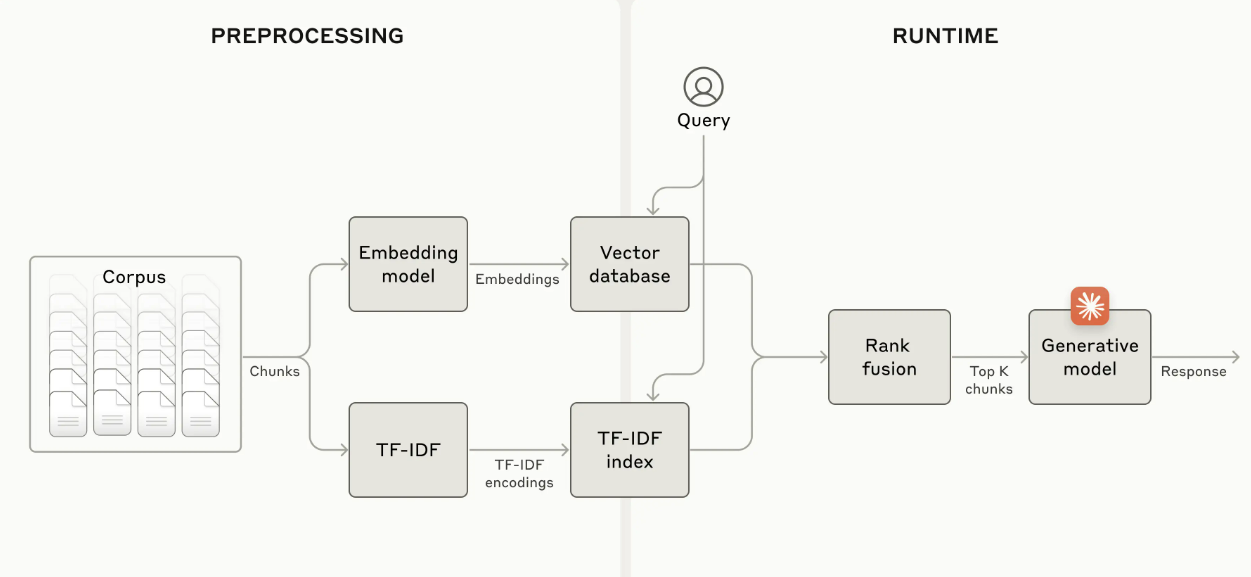

1. Break down the knowledge base (the "corpus" of documents) into smaller chunks of text, usually no more than a few hundred tokens
2. Create TF-IDF encodings and semantic embeddings for these chunks
3. Use BM25 to find top chunks based on exact matches
4. Use embeddings to find top chunks based on semantic similarity
5. Combine and deduplicate results from (3) and (4) using rank fusion techniques
6. Add the top-K chunks to the prompt to generate the response

### 2. Improved chunks by additional LLM call to add context to them from the document

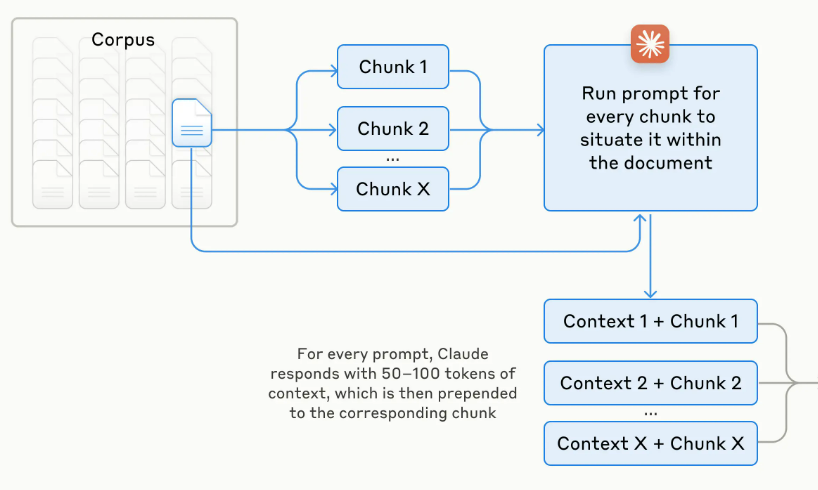

1. Pass each chunk along with the entire document to an LLM to add context to the chunk
2. Use the new chunks for TF-IDF encoding and embeddings

### **Architecture Diagram**

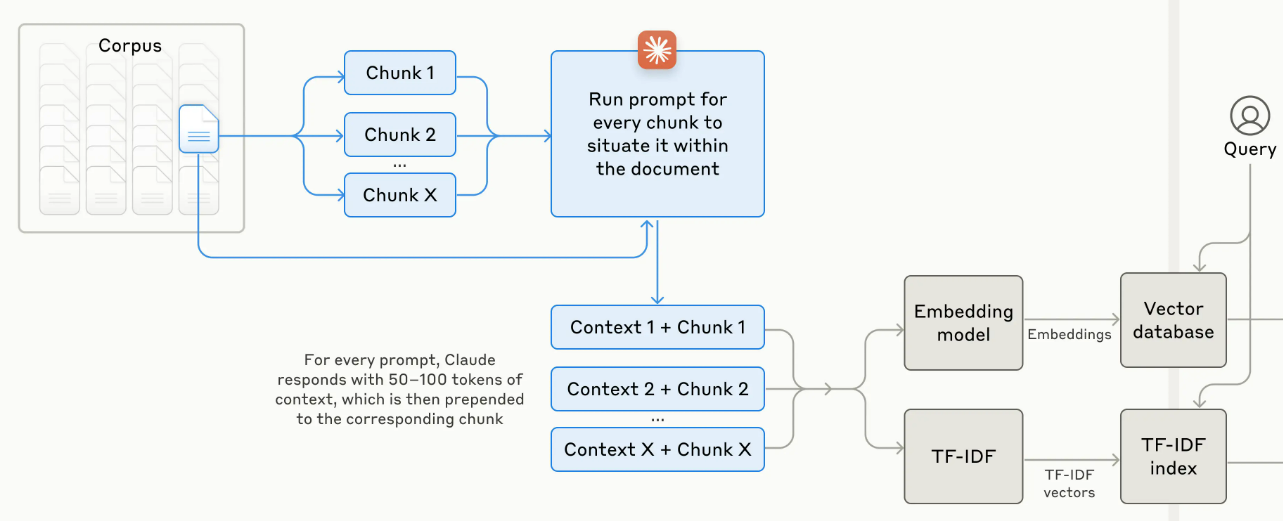

## **Details about Bruno**

**The chatbot handles:**
- Streaming output from chains in LangChain
- Streaming output from LangGraph
- Adding memory to LangGraph
- Using session IDs to maintain separate session states

**Bruno uses:**
1. LLM: Llama3-8b
2. LLM Hosting: Groq
3. Parser: PyPDFLoader from LangChain
4. Chunking: Contextual chunking
5. Embedding model: sentence-transformers/all-mpnet-base-v2 from HuggingFace
6. Retriever: Ensemble retriever (BM25 Retriever, vectordb retriever), implicit reranking
7. Vector database: Pinecone


### Importing libraries

In [1]:
from typing import Sequence
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessageChunk, HumanMessage
import os
from dotenv import load_dotenv
from pinecone import ServerlessSpec
from langchain.document_loaders import PyPDFLoader
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain.prompts import PromptTemplate



c:\Users\Kavitha\Documents\RAG Samples\rag_venv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Loading environment variables

In [2]:

load_dotenv()
pinecone_apikey=os.getenv("PINECONE_API_KEY")
pinecone_environment=os.getenv("PINECONE_ENVIRONMENT")
groq_apikey=os.getenv("GROQ_API_KEY")


### Loading LLM from Groq

In [3]:
llm = ChatGroq(model="llama3-8b-8192",groq_api_key=groq_apikey,streaming=True)

### Pinecone setup

In [3]:
from pinecone import Pinecone
pc = Pinecone(pinecone_apikey)
cloud = 'aws'
region = pinecone_environment
spec = ServerlessSpec(cloud=cloud, region=region)

### Importing embedding model from HuggingFace

In [5]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

C:\Users\Kavitha\AppData\Local\Temp\ipykernel_7716\3077754740.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
C:\Users\Kavitha\AppData\Local\Temp\ipykernel_7716\3077754740.py:2: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()


### Parsing from pdf

In [6]:
file_path = "Script.pdf"
all_text = ""
loader = PyPDFLoader(file_path)
documents = loader.load()
all_text += " ".join([doc.page_content for doc in documents])


### Chunking the text

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_text(all_text)


### Adding context to chunks

In [8]:
prompt_template = PromptTemplate(
    input_variables=["WHOLE_DOCUMENT", "CHUNK_CONTENT"],
    template=(
        "<document> {WHOLE_DOCUMENT} </document> "
        "Here is the chunk we want to situate within the whole document "
        "<chunk> {CHUNK_CONTENT} </chunk> "
        "Please give a short succinct context to situate this chunk within "
        "the overall document for the purposes of improving search retrieval "
        "of the chunk. Answer only with the succinct context and nothing else."
    )
)
processed_chunks = []
for chunk in chunks:
    # Format prompt with current chunk and whole document
    prompt = prompt_template.format(
        WHOLE_DOCUMENT=all_text,
        CHUNK_CONTENT=chunk
    )
    
    # Get LLM response
    response = llm.invoke(prompt)
    processed_chunks.append(response.content)


## Initalize BM25 Retriever
makes TF-IDF encodings under the hood

In [9]:
# initialize the bm25 retriever and faiss retriever
bm25_retriever = BM25Retriever.from_texts(
    processed_chunks
)
bm25_retriever.k = 2

### Create and store embedding in Pinecone

In [10]:
index_name="bruno"

if index_name not in pc.list_indexes().names():
    pc.create_index(index_name, dimension=768, metric="cosine",spec=spec)
else:
    print("already there")

index = pc.Index(index_name)
from langchain.vectorstores import Pinecone
vector_store = Pinecone.from_texts(processed_chunks, embeddings, index_name=index_name)
pinecone_retriever = vector_store.as_retriever(search_kwargs={"k": 2})

already there


### Combining BM25 and Pinecone retriever
Reranking happens implicitly

In [11]:
retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, pinecone_retriever], weights=[0.5, 0.5]
)

### Truncate vector database(if needed)

In [ ]:
# ## Truncating code
# index_name = "bruno"
# if index_name in pc.list_indexes().names():
#     index = pc.Index(index_name)
#     index.delete(delete_all=True)
#     print(f"Index '{index_name}' has been truncated successfully.")
# else:
#     print(f"Index '{index_name}' does not exist.")

Index 'bruno' has been truncated successfully.


### Defining prompts, chains and graphs

#### Creating retriever and chain that modifies prompt based on history

In [12]:


### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


In [ ]:
### Define system prompts for both modes ###
rag_system_prompt = (
    "You are an assistant named Bruno(inspired from your creators pet dog) for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If the context is not sufficient to answer the question, mention that you are not answering from provided context and continue to answer the question ignoring the context. Ask for additional information that could have helped to answer at the end in one line. If the context is sufficient just answer the question."
    "\n\n"
    "{context}"
)

direct_system_prompt = (
    "You are an assistant named Bruno(inspired from your creators pet dog) for question-answering tasks. "
    "Answer the question based on your general knowledge while maintaining a helpful and informative tone. "
)

### Create prompts for both modes ###
rag_qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rag_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

direct_qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", direct_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


#### Creating chains for retirval from vector db along with conext from history, also chain for just inference

In [ ]:

### Create chains for both modes ###
rag_question_answer_chain = create_stuff_documents_chain(llm, rag_qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, rag_question_answer_chain)

direct_chain = direct_qa_prompt | llm


#### Defining graph in Langgraph

In [14]:

### Statefully manage chat history ###
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str
    use_rag: bool
    
async def call_model(state: State):
    # Initialize empty accumulated state
    accumulated_state = {
        "chat_history": [],
        "context": "",
        "answer": ""
    }

    if state["use_rag"]:    
        # Stream through the RAG chain
        async for chunk in rag_chain.astream(state):
            # The chunk format depends on which part of the chain is streaming
            if "answer" in chunk:
                # Convert answer chunk to message chunk
                message_chunk = AIMessageChunk(content=chunk["answer"])
                # Yield for streaming
                yield {"messages": [message_chunk]}
                # Accumulate answer
                accumulated_state["answer"] += chunk["answer"]
                
            if "context" in chunk:
                # Accumulate context
                accumulated_state["context"] = chunk["context"]
    else:
        # Use direct chain
        async for chunk in direct_chain.astream({
            "input": state["input"],
            "chat_history": state["chat_history"]
        }):
            message_chunk = AIMessageChunk(content=chunk.content)
            yield {"messages": [message_chunk]}
            accumulated_state["answer"] += chunk.content
            
    # After streaming completes, construct final state
    yield {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(accumulated_state["answer"]),
        ],
        "context": accumulated_state["context"],
        "answer": accumulated_state["answer"]
    }


workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Inference from RAG system

In [15]:
config = {"configurable": {"thread_id": "abc123"}}
first = True

async for msg, metadata in app.astream(
    {
        "input": "What are the business implications?",
        "chat_history": [],
        "use_rag": True
    },
    stream_mode="messages",
    config=config
):
    if msg.content and not isinstance(msg, HumanMessage):
        print(f"{msg.content}", end="", flush=True)
        
    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg
    
print(f"\n--- Final Result ---\ngathered: {gathered}")

Based on the provided context, it appears that the business implications of the solution are to save time for users in understanding Bajaj's policies and services. The solution aims to achieve this by generating short, animated videos from brochure PDFs, which can be consumed quickly and efficiently, saving users 15 minutes compared to reading a brochure. This can lead to increased customer engagement, reduced time spent on decision-making, and potentially increased conversions.Based on the provided context, it appears that the business implications of the solution are to save time for users in understanding Bajaj's policies and services. The solution aims to achieve this by generating short, animated videos from brochure PDFs, which can be consumed quickly and efficiently, saving users 15 minutes compared to reading a brochure. This can lead to increased customer engagement, reduced time spent on decision-making, and potentially increased conversions.
--- Final Result ---
gathered: co